# RecB dissociation rates under endogenous damage

In [1]:
from pyberries.data import DatasetPool

data = (DatasetPool(path='/media/daniel/HDD Daniel/DanielThedie/BACMMAN/Timelapse',
                    dsList=['230725_1', '230725_2', '230126_DT23', '230719_1', '230719_2',],
                    groups=['0', '0', '0', '0', '0'],
                    filters={'all':'Frame < 50'},
                    )
        .drop_duplicates(object_name='RecB_spots', subset=['Dataset', 'Position', 'TrackHeadIndices'])
        )

Dataset 230725_1: loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230725_2: loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230126_DT23: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230719_1: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230719_2: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']


## RecB spots lifetime histogram

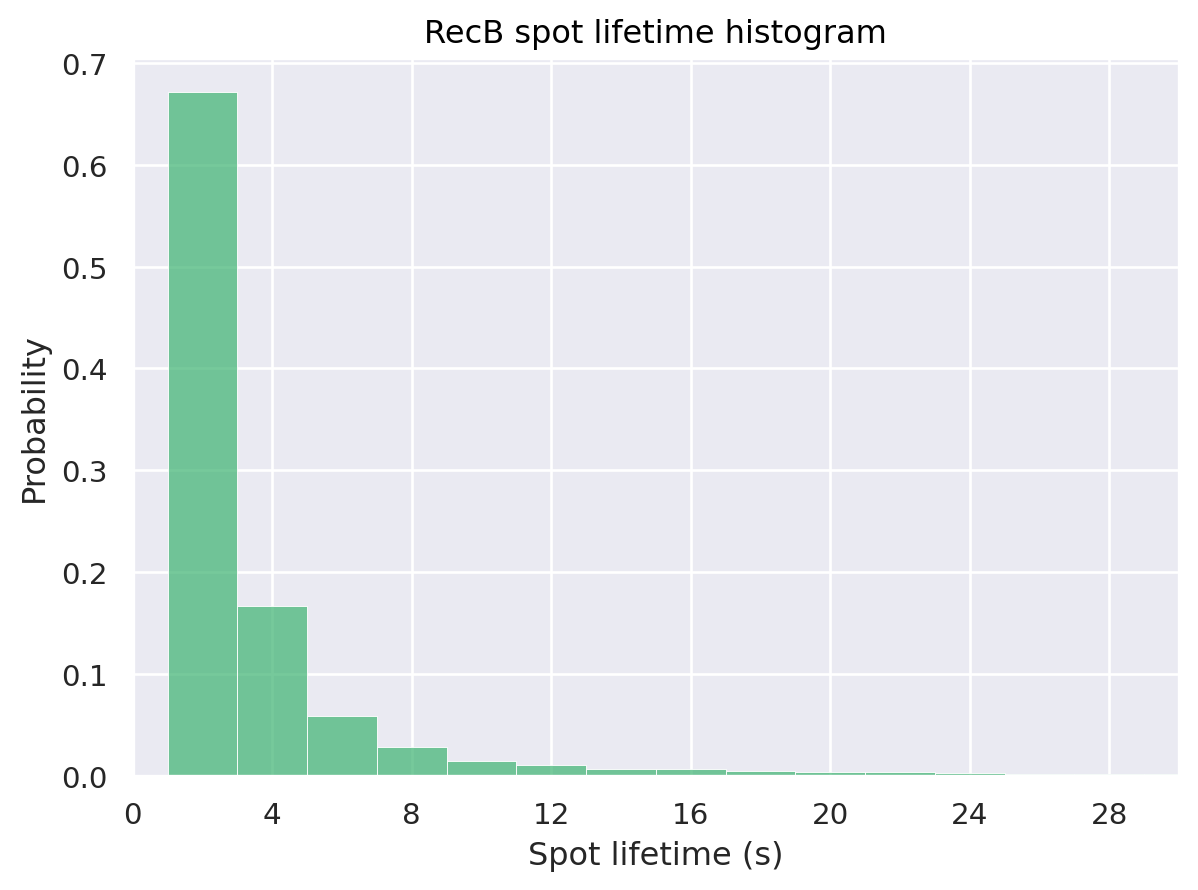

In [2]:
import seaborn.objects as so 
from pyberries.data import get_histogram

data = data.assign(object_name = 'RecB_spots', TrackLength_s=lambda df: df.TrackLength *2)

hist = get_histogram(data.RecB_spots, col='TrackLength_s', binsize=2, density=True, binlabels='left')

(
    so.Plot(hist, x='TrackLength_s', y='proportion')
    .add(so.Bars(color='mediumseagreen'))
    .limit(x=(0, 30))
    .label(x='Spot lifetime (s)', y='Probability', title='RecB spot lifetime histogram')
    .scale(x=so.Continuous().tick(every=4))
    # .save(loc='/media/daniel/HDD Daniel/DanielThedie/Figures/RecB_article_figures/1_Endogenous/Spot_lifetimes.svg', format='svg', bbox_inches='tight')
)

Compute the average and median lifetimes of RecB spots

In [24]:
(data
 .RecB_spots
 .groupby(['Group', 'Dataset'])
 .agg({'TrackLength_s':'mean'})
 .agg({'TrackLength_s':['median', 'mean', 'std']})
 )

,TrackLength_s
median,4.406788
mean,4.485074
std,0.287818


## Bleaching rate fitting

In [3]:
from pyberries.data import Fit

bleaching_fit = Fit(data.Bacteria_large, x='Frame', y='SNR', groupby=['Group', 'Dataset'], model_type='monoexp_decay_offset', p0=[data.Bacteria_large.SNR.iloc[0], 1, 0])

### Fits plotting

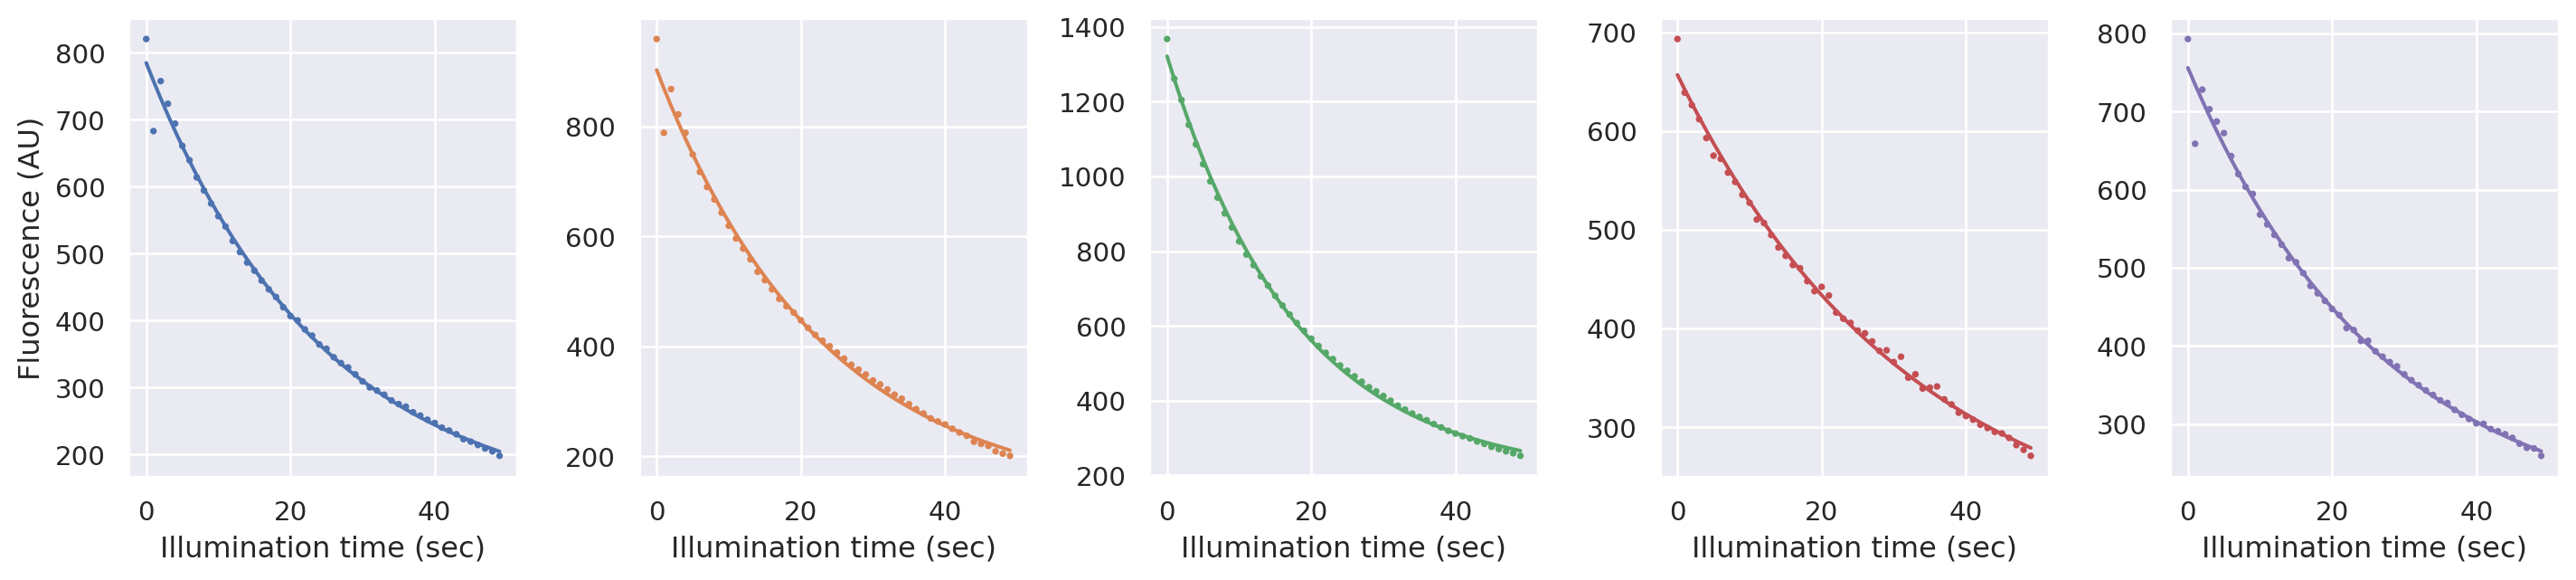

In [4]:
import seaborn.objects as so

(
    so.Plot(bleaching_fit.data, x='Frame', color='Dataset')
    .layout(size=(15, 3.5))
    .facet(col='Dataset', wrap=5)
    .add(so.Dots(marker='.', fillalpha=1), so.Agg(), y='SNR', legend=False)
    .add(so.Line(linestyle='-'), y='Fit', legend=False)
    .scale(color='deep')
    .share(y=False)
    .limit(x=(None, None), y=(None, None))
    .label(x="Illumination time (sec)", y="Fluorescence (AU)", color='', title='')
    # .save(loc='/media/daniel/HDD Daniel/Daniel Thédié/Python/RecB_article_figures/SI_Figures/Bleaching_fits_cipro0.svg', format='svg', bbox_inches='tight')
)

### Percentage of initial fluorescence remaining at the end of the acquisition

In [5]:
import pandas as pd

df = (bleaching_fit
      .data
      .query('Frame == 0 or Frame == 49')
      .pipe(lambda df: pd.pivot_table(df, values='SNR', index=['Dataset'], columns='Frame'))
      .reset_index()
      .assign(remaining_fluo=lambda df: df[49] / df[0] *100)
      )

display(df)

print(f'Average remaining fluorescence = {df.remaining_fluo.mean():.0f}% +/- {df.remaining_fluo.std():.0f}')

Frame,Dataset,0,49,remaining_fluo
0,230126_DT23,1367.582335,252.424668,18.457731
1,230719_1,693.177493,270.950936,39.088248
2,230719_2,792.823000,259.373738,32.715214
3,230725_1,820.633980,197.703789,24.091592
4,230725_2,958.870787,201.193405,20.982327


Average remaining fluorescence = 27% +/- 9


### Show fitted parameters

There are three fitted parameters in the model:
- Amplitude (adjusts the height of the first point)
- Rate (the bleaching rate)
- Offset (a constant offset that accounts for any cellular autofluorescence)

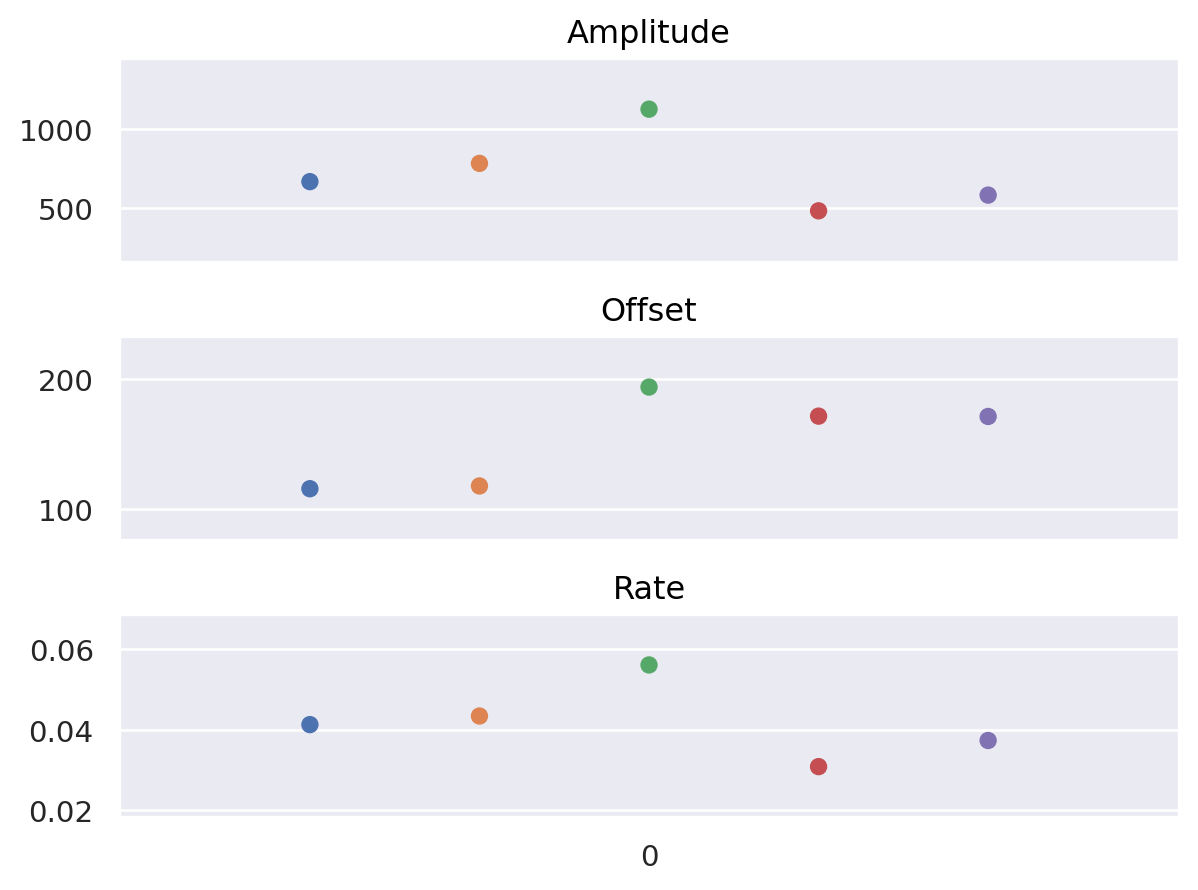

In [6]:
import seaborn.objects as so

bleaching_parameters = bleaching_fit.get_fit_parameters(param_names=['Amplitude', 'Rate', 'Offset'])

(
    so.Plot(bleaching_parameters, x='Group', y='Fitted_param', color='Dataset')
    .facet(row='Param_name')
    .add(so.Dot(), so.Dodge(), legend=False)
    .scale(color='deep')
    .share(y=False)
    .limit(y=(None, None))
    .label(x="", y="", color='')
    .theme({'axes.ymargin':0.5})
    # .save(loc='/media/daniel/HDD Daniel/Daniel Thédié/Python/RecB_article_figures/SI_Figures/Bleaching_parameters_cipro0.svg', format='svg', bbox_inches='tight')
)

### Adjust bleahcing rates to frame time

The rate fitted above is a rate "per frame". Divide it by the frame interval (sec) to obtain the bleaching rate per second (adjusted rate).

In [7]:
bleaching_rates = (bleaching_parameters
                   .query('Param_name == "Rate"')
                   .assign(Adjusted_rate=lambda df: df.Fitted_param.div(2))
                   )

display(bleaching_rates)

,Group,Fitted_param,Param_name,Dataset,Adjusted_rate
1,0,0.041263,Rate,230725_1,0.020632
4,0,0.043411,Rate,230725_2,0.021705
7,0,0.056136,Rate,230126_DT23,0.028068
10,0,0.030790,Rate,230719_1,0.015395
13,0,0.037309,Rate,230719_2,0.018654


## RecB spot lifetime fit

### A monoexponential decay does not fit the histograms

In [8]:
from pyberries.data import Fit, get_histogram

hist = get_histogram(data.RecB_spots, col='TrackLength', binsize=1, groupby=['Group'], density=True, binlabels='left')
monoexp_fit = Fit(hist, x='TrackLength', y='proportion', model_type='monoexp_decay',
                   groupby=['Group'], p0=[1, 1])

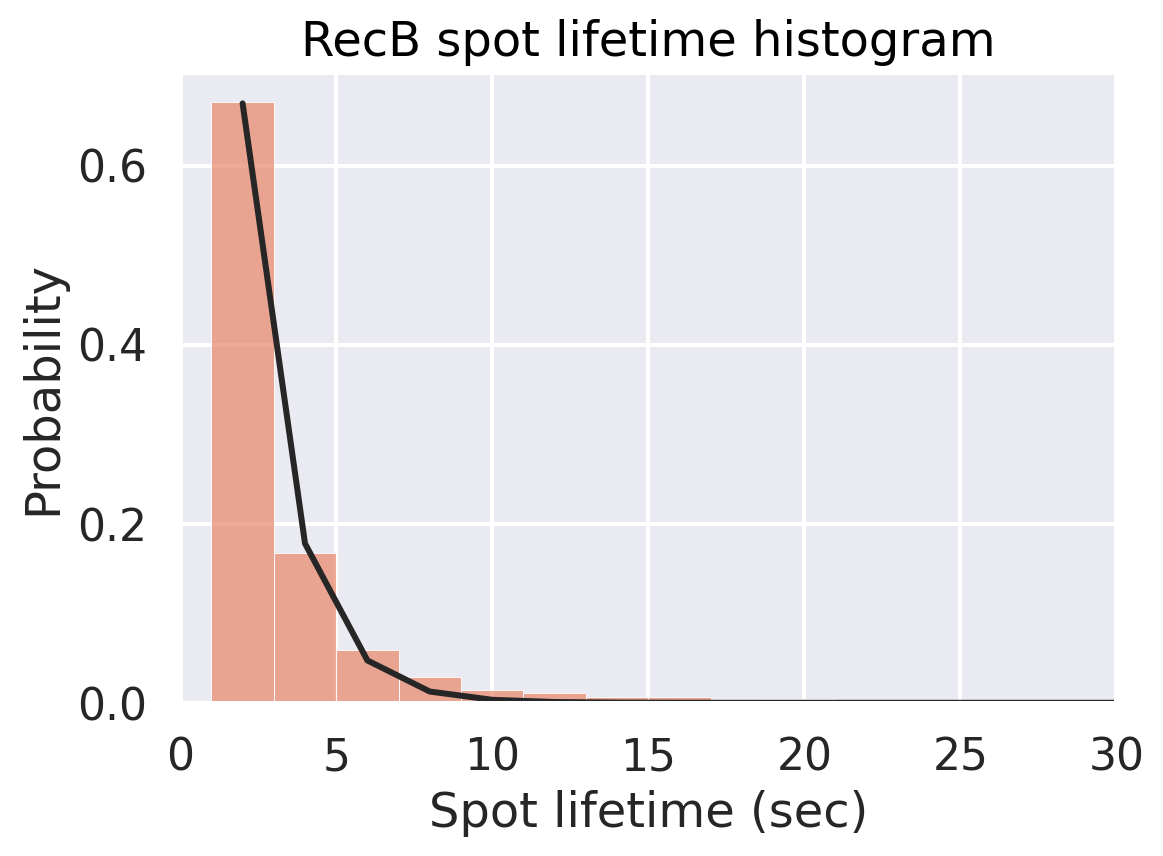

In [41]:
import seaborn.objects as so
import seaborn as sns

df = (monoexp_fit
      .data
      .assign(TrackLength_s=lambda df: df.TrackLength *2)
      )

color = sns.color_palette('flare', 5)[0]

(
    so.Plot(df, x='TrackLength_s')
    .add(so.Bars(color=color), y='proportion', legend=False)
    .add(so.Line(color='k'), y='Fit', legend=False)
    .limit(x=(0, 30), y=(None, None))
    .theme(sns.plotting_context('talk'))
    .label(x="Spot lifetime (sec)", y="Probability", color='', title='RecB spot lifetime histogram')
    .save(loc='/media/daniel/HDD Daniel/DanielThedie/Figures/RecB_article_figures/1_Endogenous/Fit_monoexp.svg', format='svg', bbox_inches='tight')
)

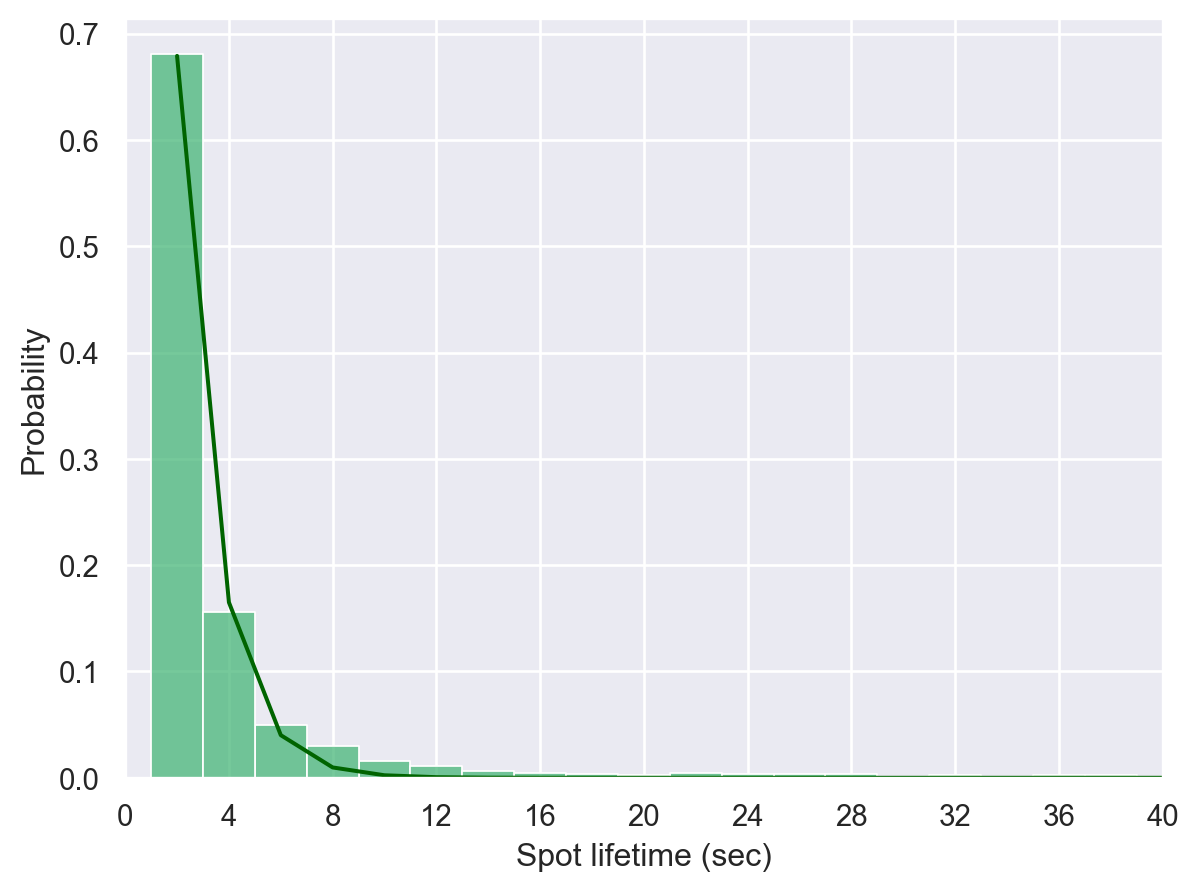

In [6]:
df = (monoexp_fit.data
      .query('Dataset == "230719_2"')
      .assign(TrackLength_s=lambda df: df.TrackLength * 2)
      )

(
    so.Plot(df, x='TrackLength_s')
    .add(so.Bars(color='mediumseagreen'), y='proportion', legend=False)
    .add(so.Line(color='darkgreen'), y='Fit', label='Fit', legend=False)
    .scale(x=so.Continuous().tick(every=4))
    .limit(x=(0, 40), y=(None, None))
    .label(x="Spot lifetime (sec)", y="Probability", color='', title='')
    # .save(loc='M:\\Figures\\231004_article_figures\\1_Endogenous\\Fit_monoexp.svg', format='svg', bbox_inches='tight')
)

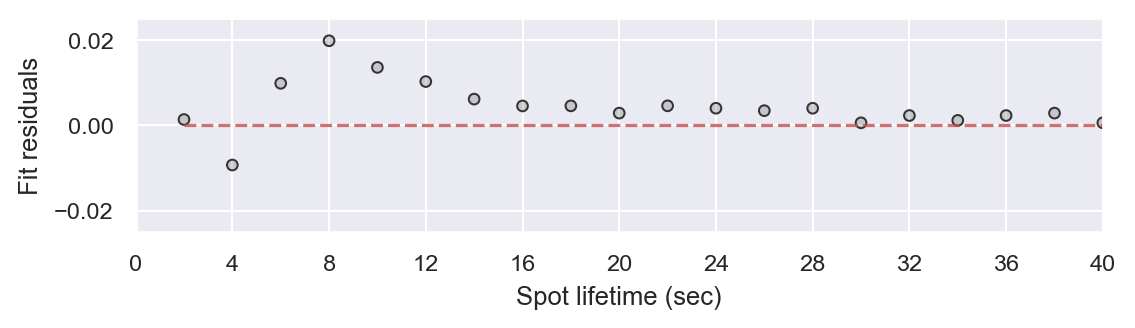

In [6]:
from seaborn import plotting_context

df = df.assign(ref=0)

(
    so.Plot(df, x='TrackLength_s', y='Residuals')
    .layout(size=(6, 1.8))
    .add(so.Dots(color='.2'), legend=False)
    .add(so.Line(color='r', linestyle='--', alpha=0.8), y='ref', legend=False)
    .scale(x=so.Continuous().tick(every=4))
    .limit(x=(0, 40), y=(-0.025, 0.025))
    .label(x="Spot lifetime (sec)", y="Fit residuals", color='', title='')
    .theme(plotting_context("paper"))
    .save(loc='M:\\Figures\\231004_article_figures\\1_Endogenous\\Res_monoexp.svg', format='svg', bbox_inches='tight')
)

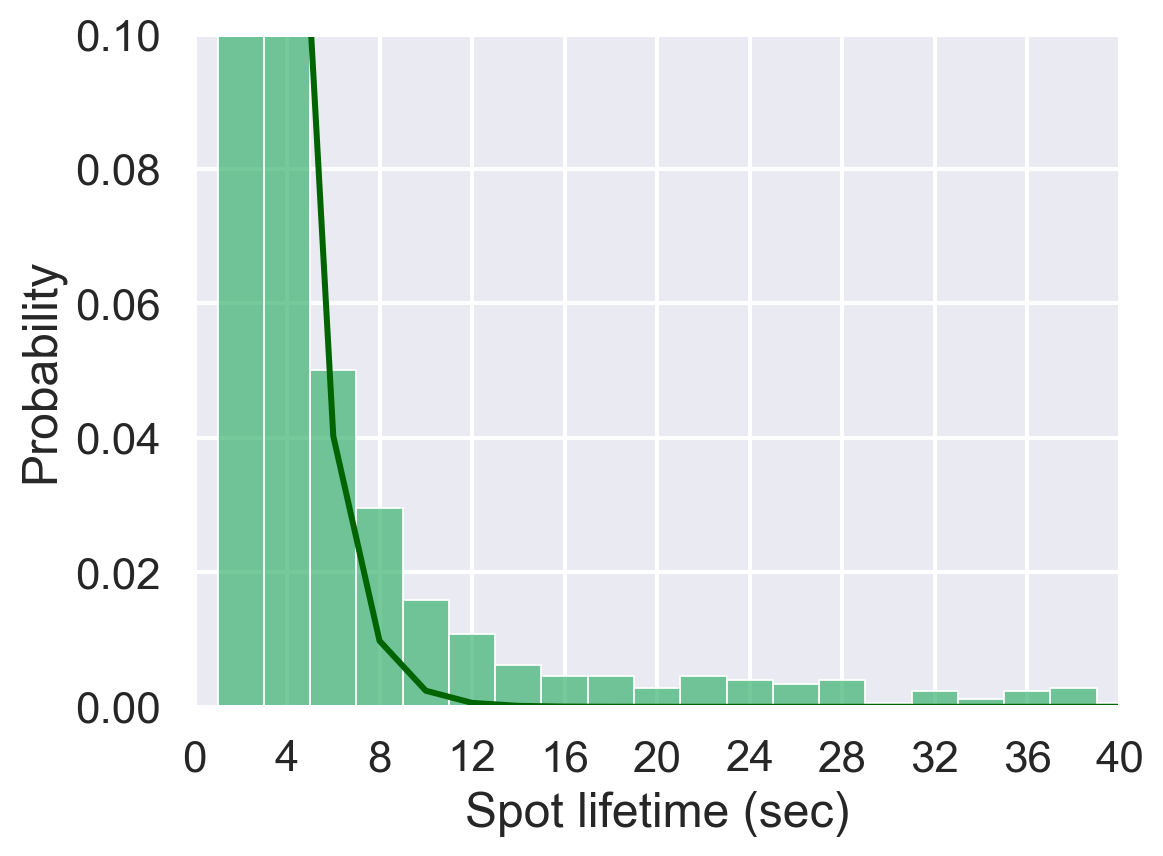

In [11]:
from seaborn import plotting_context

(
    so.Plot(df, x='TrackLength_s')
    .add(so.Bars(color='mediumseagreen'), y='proportion', legend=False)
    .add(so.Line(color='darkgreen'), y='Fit', legend=False)
    .scale(x=so.Continuous().tick(every=4))
    .limit(x=(0, 40), y=(None, 0.1))
    .label(x="Spot lifetime (sec)", y="Probability", color='', title='')
    .theme(plotting_context("talk"))
    .save(loc='M:\\Figures\\231004_article_figures\\1_Endogenous\\Fit_inset_monoexp.svg', format='svg')
)

### A bi-exponential decay fits the histograms much better

In [39]:
from pyberries.data import Fit, get_histogram

hist = get_histogram(data.RecB_spots, col='TrackLength', binsize=1, groupby=['Dataset','Group'], density=True, binlabels='left')
biexp_fit = Fit(hist, x='TrackLength', y='proportion', model_type='biexp_decay',
                   groupby=['Dataset','Group'], p0=[1, 1, 0.1, 0.1])

In [40]:
from pyberries.data import get_model
import pandas as pd

monoexp_decay = get_model('monoexp_decay')

fit_params = biexp_fit.get_fit_parameters(param_names=['a1', 'b1', 'a2', 'b2'])

biexp_fit.data[['Fit_fast', 'Fit_slow', 'p_slow']] = pd.DataFrame(columns=['Fit_fast', 'Fit_slow', 'p_slow'], dtype='float64')
for ds, df in biexp_fit.data.groupby('Dataset'):
    params = fit_params.query('Dataset == @ds')
    df = (df
          .assign(Fit_fast = lambda df: monoexp_decay(df.TrackLength, a=params.Fitted_param.iloc[0], b=params.Fitted_param.iloc[1]),
                  Fit_slow = lambda df: monoexp_decay(df.TrackLength, a=params.Fitted_param.iloc[2], b=params.Fitted_param.iloc[3]),
                  p_slow = lambda df: df.Fit_slow/(df.Fit_slow + df.Fit_fast))
          )
    biexp_fit.data.loc[biexp_fit.data.Dataset == ds,:] = df

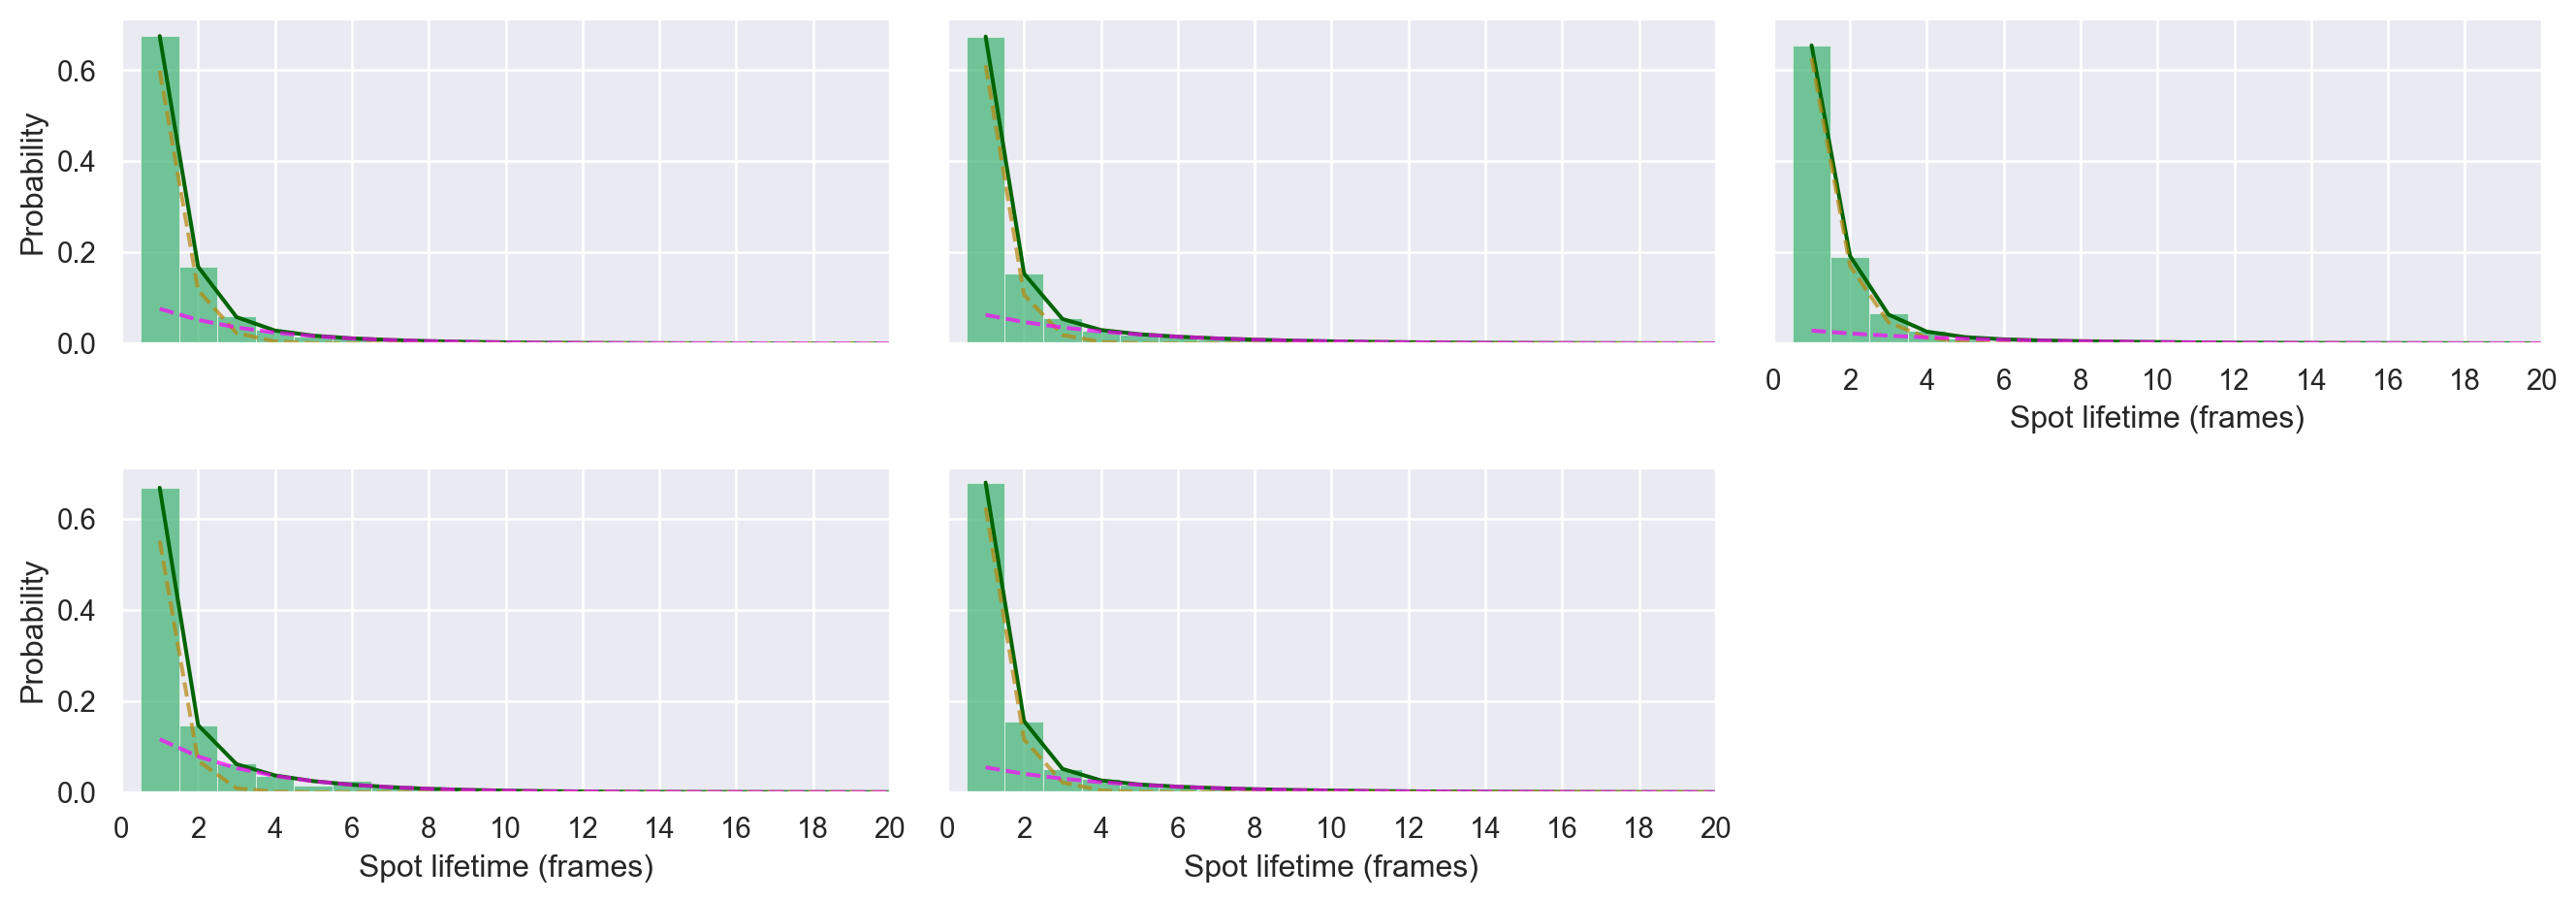

In [4]:
import seaborn.objects as so

(
    so.Plot(biexp_fit.data, x='TrackLength')
    .layout(size=(14, 5))
    .facet(col='Dataset', wrap=3)
    .add(so.Bars(color='mediumseagreen'), y='proportion', legend=False)
    .add(so.Line(color='darkgreen'), y='Fit', legend=False)
    .add(so.Line(linestyle='--', color='darkgoldenrod', alpha=0.7), y='Fit_fast', legend=False)
    .add(so.Line(linestyle='--', color='fuchsia', alpha=0.7), y='Fit_slow', legend=False)
    .scale(x=so.Continuous().tick(every=2))
    .limit(x=(0, 20), y=(None, None))
    .label(x="Spot lifetime (frames)", y="Probability", color='', title='')
)

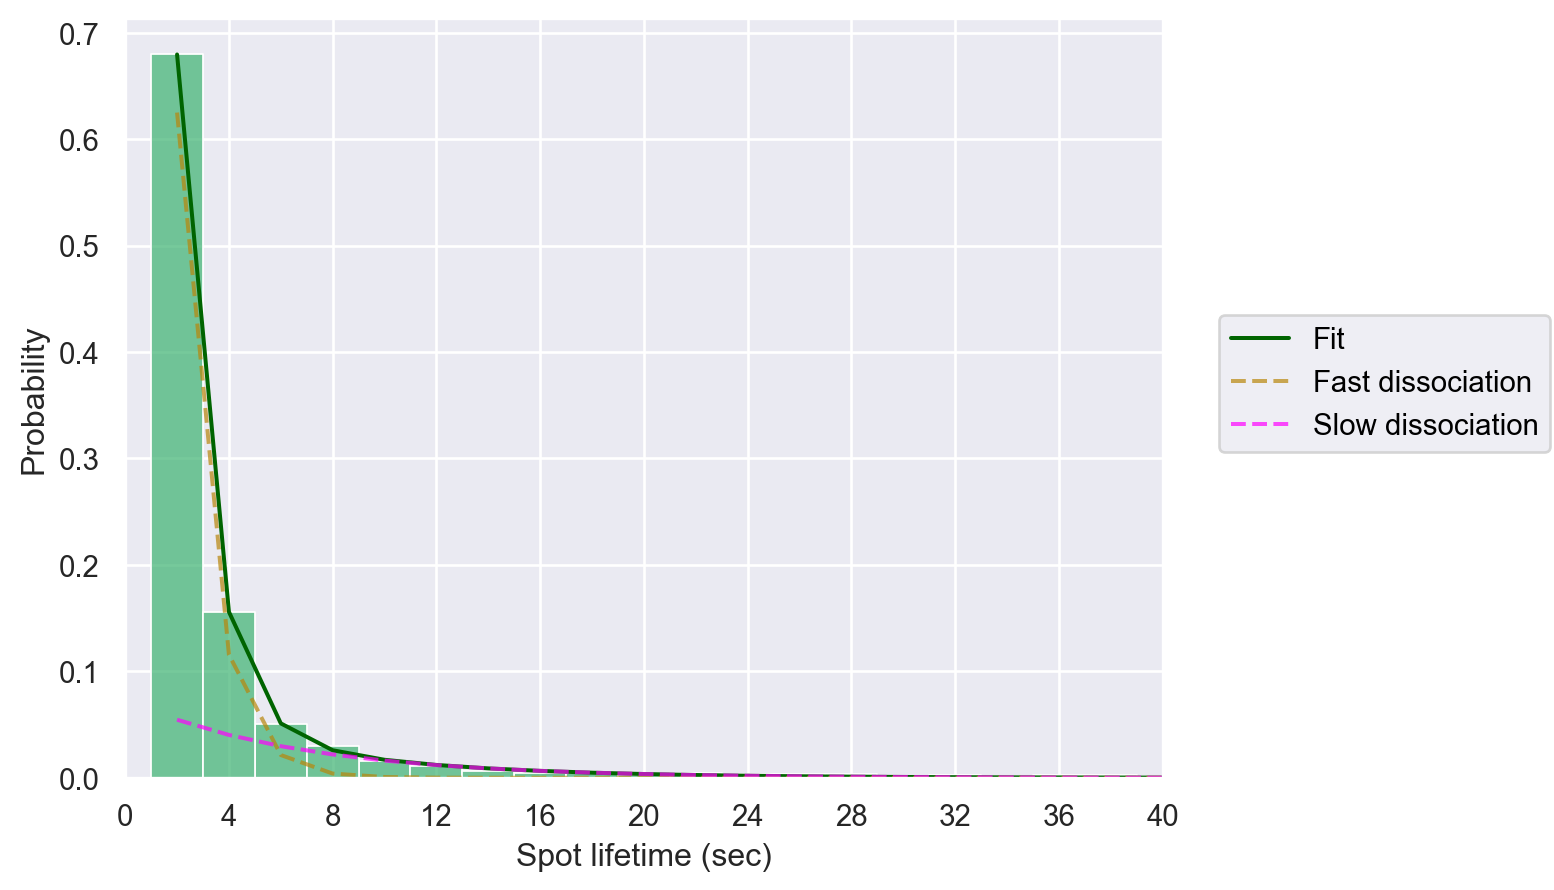

In [10]:
import seaborn.objects as so

df = (biexp_fit.data
      .query('Dataset == "230719_2"')
      .assign(TrackLength_s=lambda df: df.TrackLength * 2)
      )

(
    so.Plot(df, x='TrackLength_s')
    .add(so.Bars(color='mediumseagreen'), y='proportion', legend=False)
    .add(so.Line(color='darkgreen'), y='Fit', label='Fit')
    .add(so.Line(linestyle='--', color='darkgoldenrod', alpha=0.7), y='Fit_fast', label='Fast dissociation')
    .add(so.Line(linestyle='--', color='fuchsia', alpha=0.7), y='Fit_slow', label='Slow dissociation')
    .scale(x=so.Continuous().tick(every=4))
    .limit(x=(0, 40), y=(None, None))
    .label(x="Spot lifetime (sec)", y="Probability", color='', title='')
    .save(loc='M:\\Figures\\240202_EDDR_Poster\\Fit_biexp.svg', format='svg', bbox_inches="tight")
)

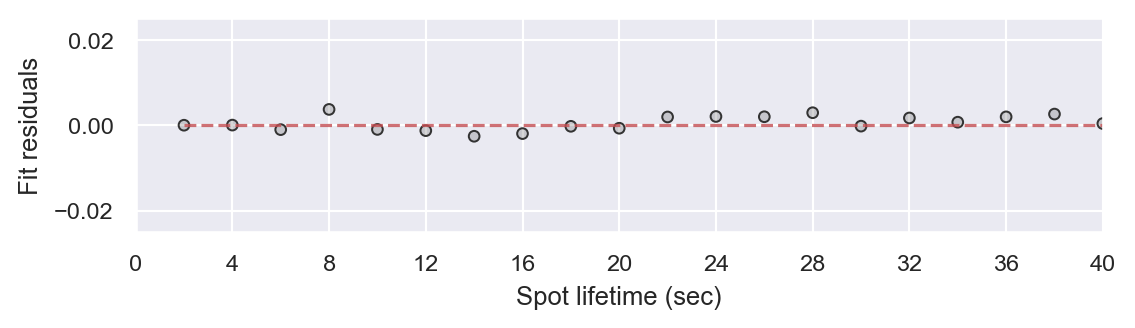

In [16]:
from seaborn import plotting_context

df = df.assign(ref=0)

(
    so.Plot(df, x='TrackLength_s', y='Residuals')
    .layout(size=(6, 1.8))
    .add(so.Dots(color='.2'), legend=False)
    .add(so.Line(color='r', linestyle='--', alpha=0.8), y='ref', legend=False)
    .scale(x=so.Continuous().tick(every=4))
    .limit(x=(0, 40), y=(-0.025, 0.025))
    .label(x="Spot lifetime (sec)", y="Fit residuals", color='', title='')
    .theme(plotting_context("paper"))
    # .save(loc='M:\\Figures\\231004_article_figures\\1_Endogenous\\Res_biexp.svg', format='svg')
)

#### Inset (zoom on histogram tail)

Note: for higher zoom use "poster" context.

Available contexts are: notebook (default), paper, talk, poster.

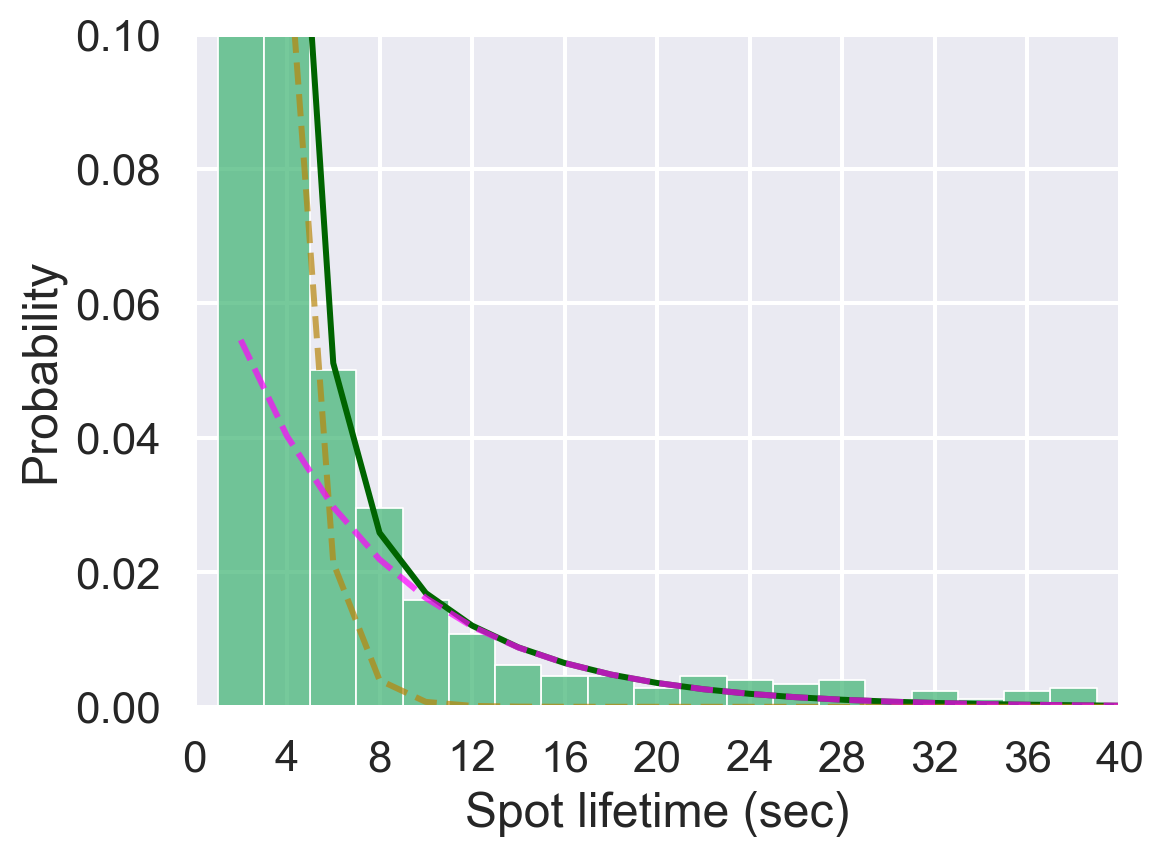

In [17]:
from seaborn import plotting_context

(
    so.Plot(df, x='TrackLength_s')
    .add(so.Bars(color='mediumseagreen'), y='proportion', legend=False)
    .add(so.Line(color='darkgreen'), y='Fit', legend=False)
    .add(so.Line(linestyle='--', color='darkgoldenrod', alpha=0.7), y='Fit_fast', legend=False)
    .add(so.Line(linestyle='--', color='fuchsia', alpha=0.7), y='Fit_slow', legend=False)
    .scale(x=so.Continuous().tick(every=4))
    .limit(x=(0, 40), y=(None, 0.1))
    .label(x="Spot lifetime (sec)", y="Probability", color='', title='')
    .theme(plotting_context("talk"))
    # .save(loc='M:\\Figures\\231004_article_figures\\1_Endogenous\\Fit_inset_biexp.svg', format='svg')
)

#### Akaike's Information Criteria

Use AIC to check if the biexponential model does indeed fit the data better (apart from just having more parameters).

Lower AIC values mean better fit, so here we can conclude that the biexponential model is a better fit than the monoexponential.

In [18]:
print(f'AIC (mono-exponential fit): {monoexp_fit.aic}')
print(f'AIC (bi-exponential fit): {biexp_fit.aic}')

AIC (mono-exponential fit): {'230726_cipro0--0': -211.15532845966177, '230905_1--1': -350.9209700647813, '230905_2--2': -351.1574119572546, '230725_1--3': -268.1571073781869, '230725_2--4': -240.6362912919713, '230809_1--5': -278.51571101114496, '230126_DT23--6': -444.1260371664046, '230719_1--7': -97.20148156135178, '230719_2--8': -278.3550806111309}
AIC (bi-exponential fit): {'230726_cipro0--0': -284.5701604939143, '230905_1--1': -484.74678609776964, '230905_2--2': -460.76212331773183, '230725_1--3': -365.9739897996742, '230725_2--4': -360.36264535948413, '230809_1--5': -389.9244719777108, '230126_DT23--6': -530.1533333318247, '230719_1--7': -134.90682094812055, '230719_2--8': -370.5041094254539}


#### Log-likelihood test for nested models

This uses the log-likelihood value and Chi-squared distribution to produce a p-value.

p < 0.05 means that the bi-exponential model fits the data better than the mono-exponential model.

In [6]:
from scipy.stats import chi2

for grp in monoexp_fit.llf.keys():
    LR_statistic = -2*(monoexp_fit.llf[grp] - biexp_fit.llf[grp])
    p_val = chi2.sf(LR_statistic, 2)
    print(f'{grp}: p-value = {p_val}')

230725_1--0: p-value = 6.027160598881866e-23
230725_2--1: p-value = 5.262442604426232e-28
230126_DT23--2: p-value = 2.8237160826579765e-20
230719_1--3: p-value = 8.786190579206016e-10
230719_2--4: p-value = 1.3228288949988035e-21


### Proportions of the two populations

In [41]:
rates = biexp_fit.get_rates(dt=2, offset=list(bleaching_rates.Adjusted_rate))

slow_rates = rates.query('Rate_type == "Slow"')
fast_rates = rates.query('Rate_type == "Fast"')

rates['Lifetime'] = 1/rates.Rate
display(rates.groupby('Rate_type', observed=False)['Lifetime'].agg(['mean', 'std']))

print(f'The long-lived population represents {slow_rates.Population.mean()*100:.2f} +/- {slow_rates.Population.std()*100:.2f} % of RecB molecules')
print(f'The short-lived population represents {fast_rates.Population.mean()*100:.2f} +/- {fast_rates.Population.std()*100:.2f} % of RecB molecules')

,mean,std
Rate_type,,
Fast,1.244261,0.229371
Slow,7.437411,1.938667


The long-lived population represents 2.65 +/- 0.94 % of RecB molecules
The short-lived population represents 97.35 +/- 0.94 % of RecB molecules


## Glycerol data

In [15]:
from pyberries.data import DatasetPool

data = (DatasetPool(path='D:\Daniel\BACMMAN\Timelapse',
                    dsList=['230929_3'],
                    groups=['Glycerol'],
                    metadata={},
                    filters={'all':'Frame < 50'}
                    )
        .drop_duplicates(object_name='RecB_spots', subset=['Dataset', 'Position', 'TrackHeadIndices'])
        )

Dataset 230929_3: loaded objects ['Bacteria_large', 'DnaN_spots', 'DnaN_raw', 'RecB_spots', 'RecB_raw']


### TO DO
Add bleaching rate fit

### Mono-exponential fit

In [16]:
from pyberries.data import Fit, get_histogram

hist = get_histogram(data.RecB_spots, col='TrackLength', binsize=1, groupby=['Dataset','Group'], density=True, binlabels='left')
monoexp_fit = Fit(hist, x='TrackLength', y='proportion', model_type='monoexp_decay',
                   groupby=['Dataset','Group'], p0=[1, 1])

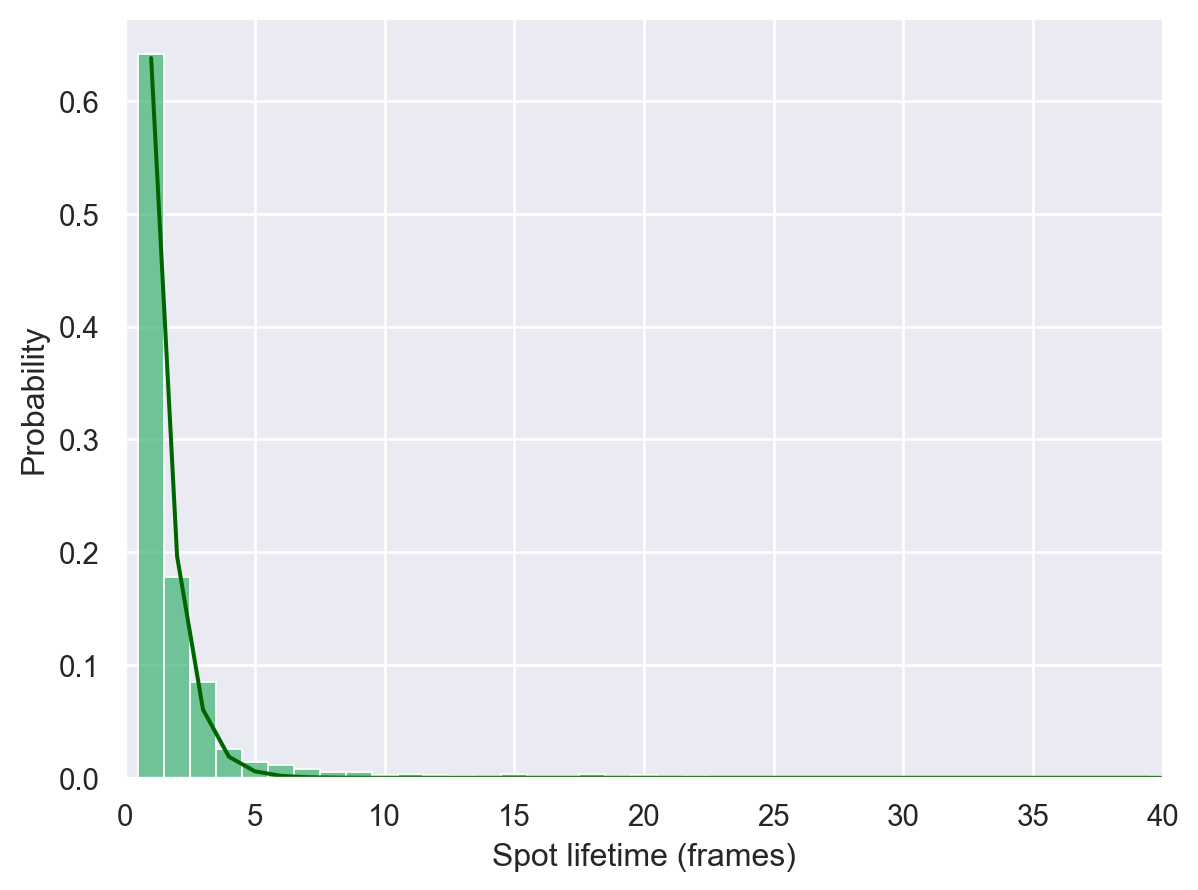

In [20]:
import seaborn.objects as so

(
    so.Plot(monoexp_fit.data, x='TrackLength')
    .facet(col='Dataset', wrap=3)
    .add(so.Bars(color='mediumseagreen'), y='proportion', legend=False)
    .add(so.Line(color='darkgreen'), y='Fit', legend=False)
    .limit(x=(0, 40), y=(None, None))
    .label(x="Spot lifetime (frames)", y="Probability", color='', title='')
)

### Bi-exponential fit

In [27]:
from pyberries.data import Fit, get_histogram

hist = get_histogram(data.RecB_spots, col='TrackLength', binsize=1, groupby=['Dataset','Group'], density=True, binlabels='left')
biexp_fit = Fit(hist, x='TrackLength', y='proportion', model_type='biexp_decay',
                   groupby=['Dataset','Group'], p0=[1.5, 1, 0.15, 0.1])

Fit for dataset ('230929_3', 'Glycerol') failed: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.


In [5]:
from pyberries.data import get_model

monoexp_decay = get_model('monoexp_decay')

fit_params = biexp_fit.get_fit_parameters(param_names=['a1', 'b1', 'a2', 'b2'])

biexp_fit.data[['Fit_fast', 'Fit_slow', 'p_slow']] = 0
for ds, df in biexp_fit.data.groupby('Dataset'):
    params = fit_params.query('Dataset == @ds')
    df = (df
          .assign(Fit_fast = lambda df: monoexp_decay(df.TrackLength, a=params.Fitted_param.iloc[0], b=params.Fitted_param.iloc[1]),
                  Fit_slow = lambda df: monoexp_decay(df.TrackLength, a=params.Fitted_param.iloc[2], b=params.Fitted_param.iloc[3]),
                  p_slow = lambda df: df.Fit_slow/(df.Fit_slow + df.Fit_fast))
          )
    biexp_fit.data.loc[biexp_fit.data.Dataset == ds,:] = df

In [ ]:
import seaborn.objects as so

(
    so.Plot(biexp_fit.data, x='TrackLength')
    # .layout(size=(14, 5))
    .facet(col='Dataset', wrap=3)
    .add(so.Bars(color='mediumseagreen'), y='proportion', legend=False)
    .add(so.Line(color='darkgreen'), y='Fit', legend=False)
    .add(so.Line(linestyle='--', color='darkgoldenrod', alpha=0.7), y='Fit_fast', legend=False)
    .add(so.Line(linestyle='--', color='fuchsia', alpha=0.7), y='Fit_slow', legend=False)
    .scale(x=so.Continuous().tick(every=2))
    .limit(x=(0, 50), y=(None, None))
    .label(x="Spot lifetime (frames)", y="Probability", color='', title='')
)